In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import torch.optim as optim

import plotly.graph_objects as go

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(1, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        # x = self.flatten(x)
        dh = self.linear_tanh_stack(x)
        return dh

In [4]:
q_transfer_ANN = NeuralNetwork().to(device)
print(q_transfer_ANN)

NeuralNetwork(
  (linear_tanh_stack): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [5]:
#100 values between -1 and 1
original_x_values = (np.random.random((100,1))-0.5)*2

In [6]:
#Generator function to create the y values
def get_y_deterministic_value(x_value):
    value = x_value[0]
    if value>0.0:
        y_value = np.tanh(value)
    else:
        y_value = 0.2
    return y_value

In [7]:
y_values = np.array(list(map(get_y_deterministic_value, original_x_values)))

In [8]:
fig = go.Figure(go.Scatter(x = original_x_values[:,0], y = y_values, mode = 'markers'))
fig.show()

In [9]:
x_input_ANN = torch.tensor(original_x_values, dtype=torch.float)

In [10]:
def get_piecewise_ANN_or_constant(X, model):
    # print(X)
    if torch.ge(X[0], 0.0):
        y=model(X)
    else:
        # print('here')
        y = 0.2
    
    return y

In [11]:
# for i,j in enumerate(results_of_the_model):
#     print(i, j, y_values[i])

In [12]:
constant_torch = torch.tensor(20, dtype=torch.float)
real = torch.tensor(y_values, dtype=torch.float)+constant_torch

In [13]:
real

tensor([20.2000, 20.2000, 20.2000, 20.2000, 20.2000, 20.6783, 20.2000, 20.3610,
        20.2000, 20.4247, 20.2000, 20.2000, 20.3476, 20.1752, 20.2000, 20.7053,
        20.2000, 20.2000, 20.5134, 20.4767, 20.3088, 20.5845, 20.2000, 20.2000,
        20.3586, 20.2000, 20.2000, 20.3438, 20.5531, 20.2629, 20.2000, 20.2000,
        20.2000, 20.2000, 20.1930, 20.1069, 20.2000, 20.6252, 20.2000, 20.7033,
        20.2000, 20.2000, 20.2000, 20.2000, 20.2000, 20.2000, 20.0293, 20.6579,
        20.2000, 20.2000, 20.5827, 20.3728, 20.2000, 20.7399, 20.3616, 20.2463,
        20.2000, 20.2000, 20.2000, 20.2000, 20.3264, 20.6876, 20.2000, 20.5224,
        20.2000, 20.1301, 20.2000, 20.2000, 20.4507, 20.2000, 20.0047, 20.6188,
        20.6922, 20.7567, 20.2000, 20.6916, 20.7354, 20.2000, 20.2546, 20.2000,
        20.2000, 20.2000, 20.0113, 20.2000, 20.3452, 20.2000, 20.0441, 20.0351,
        20.2000, 20.2000, 20.2000, 20.2000, 20.2000, 20.1863, 20.2000, 20.2000,
        20.1719, 20.2000, 20.2000, 20.20

In [14]:
optimizer = optim.SGD(q_transfer_ANN.parameters(), lr=0.01, momentum=0.9)
losses=[]
for epoch in range(1000):
    # Load data to device
    # x, y = batch[0].to(device), batch[1].to(device)
    results_of_the_model = []
    for i in x_input_ANN:
        results_of_the_model.append(get_piecewise_ANN_or_constant(i, q_transfer_ANN))


    tensors_in_y = []
    for i in results_of_the_model:
        if type(i)==torch.Tensor:
            tensors_in_y.append(i)
        else:
            value_in_torch = torch.tensor([i], dtype=torch.float)
            tensors_in_y.append(value_in_torch)

    # Model prediction
    preds = torch.cat(tensors_in_y) + constant_torch
    
    # MSE loss function
    loss = nn.MSELoss()(preds, real)
        
    losses.append(loss.detach())
    
    # Backpropagate and update weights
    loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)        

<AxesSubplot:>

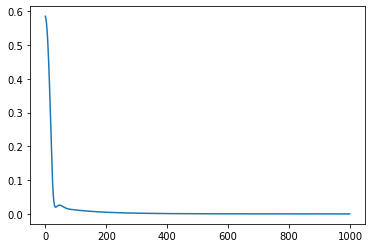

In [15]:
pd.Series(np.array(losses)).plot()

In [16]:
test_x_values = (np.random.random((100,1))-0.5)*2
test_x_input_ANN = torch.tensor(test_x_values, dtype=torch.float)

test_results_of_the_model = []
for i in test_x_input_ANN:
    test_results_of_the_model.append(get_piecewise_ANN_or_constant(i, q_transfer_ANN)+ constant_torch)

In [17]:
test_results_of_the_model[2]

tensor([20.6380], grad_fn=<AddBackward0>)

In [18]:
test_tensors_in_y = []
for i in test_results_of_the_model:
    if type(i)!=torch.Tensor:
        test_tensors_in_y.append(i)
    else:
        value_in_torch = i.detach().item()#torch.tensor([i], dtype=torch.float)
        test_tensors_in_y.append(value_in_torch)

In [20]:
fig = go.Figure(go.Scatter(x = test_x_values[:,0], y = test_tensors_in_y, mode = 'markers'))

fig.add_trace(go.Scatter(x = original_x_values[:,0], y = y_values+20, mode = 'markers'))

fig.show()

In [122]:
for i in q_transfer_ANN.named_parameters():
    print(i)

('linear_tanh_stack.0.weight', Parameter containing:
tensor([[0.9979]], requires_grad=True))
('linear_tanh_stack.0.bias', Parameter containing:
tensor([0.0007], requires_grad=True))
